# Using MonoTools fit

Here we will go through a few examples of how to fit a mono (one transit) or duo (two transit) transiting planet system using MonoTools.

This will cover:
* Accessing lightcurve & stellar parameter data
* Fitting duotransits and monotransits by marginalising over discrete parameter spaces in multiple parameters
* Fitting such systems using the in-built margnial velocity interpolator (fastest method)
* Fitting systems which also have RVs
* Plotting the outputs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

#The following may need to be MonoTools.MonoTools if you are importing from outside this folder:
from MonoTools import fit, lightcurve, tools

All data is stored in the following path which you can update in the commandline using $MONOTOOLSPATH

In [2]:
tools.MonoData_savepath,tools.MonoData_tablepath

('/Volumes/LUVOIR/MonoToolsData',
 '/Users/hugh/Postdoc/MonoTools/MonoTools/data/tables')

### Loading Lightcurves & Stellar Params

Lightcurves are a dictionary with a few important arrays - `time`, `flux`, `flux_err` as well as:
* `cadence` - in the form "[mission letter][cadence in nearest minute]", e.g. T2 (for 2-minute TESS data), or K30 (for 30-min Kepler or K2 data). This should ideally be in an array form with matching length to `time`
* `mask` - in the form of a boolean, where those True points are the cadences to be used.
* `jd_base` - zero-point of time in BJD

However, you don't need to worry about this, because you can load lightcurves from all surveys using:

Getting all IDs
Accessing online catalogues to match ID to RA/Dec (may be slow) mission= tess
Sector 64 not (yet) found on MAST | RESPONCE:404
Sector 64 not (yet) found on MAST | RESPONCE:404
Sector 65 not (yet) found on MAST | RESPONCE:404


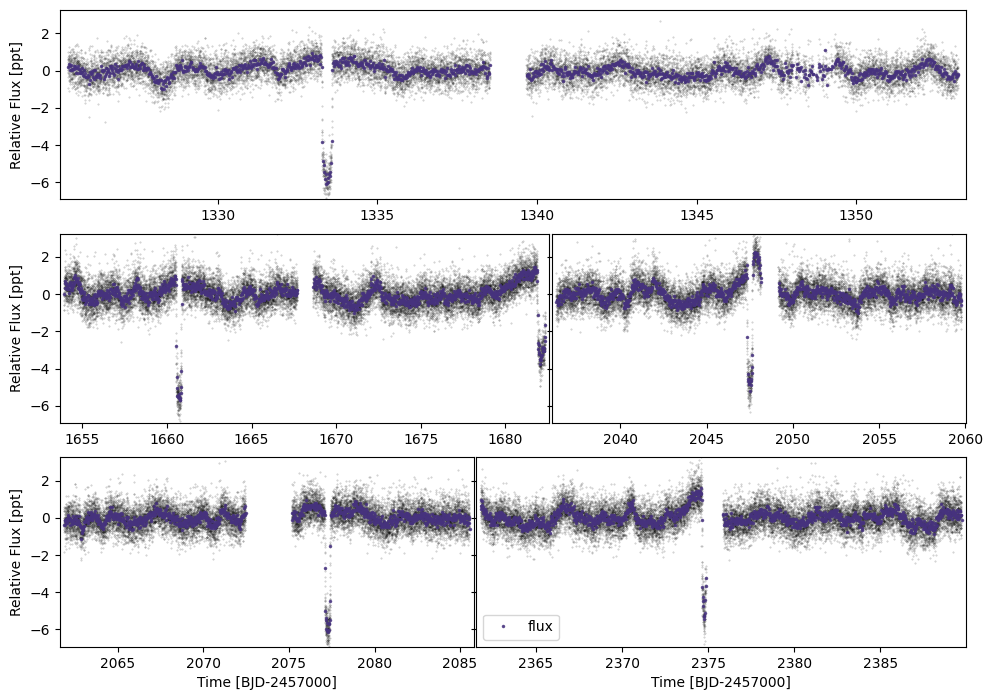

In [3]:
lc = lightcurve.multilc(270341214, 'tess', load=False)
lc.plot()

This candidate has both a monotransit and an inner multi-transiting planet, so is perfect for testing our code.

#### Priming the model:
Ok, first we need to initialise our model using the lightcurve and ID:

In [4]:
model = fit.monoModel(270341214, 'tess', lc=lc)

Next we need to add stellar parameters. There are two ways to do this:
1) Let MonoTools take the TICv8 parameters (this will automatically happen if you do not call `init_starpars`
2) Give specific parameters and errors (in the form [value, neg_error, pos_error])

In [5]:
model.init_starpars()

In [ ]:
# Adding specific stellar parameters:
model.init_starpars(Rstar=[],
                    rhostar=info[['rho','eneg_rho','epos_rho']].values,
                    Teff=info[['teff','eneg_teff','epos_teff']].values,
                    logg=info[['logg','eneg_logg','epos_logg']].values,
                    FeH=0.0)

Now we're ready to start adding planets to the model. We can either use `add_mono`, `add_duo` and `add_multi`, or we can use `model.add_planet()` with the planet type specified. Here we'll use the former:

As we have a very deep and high-SNR transit for planet c, we can set `gap_width_thresh=0.8` which is the width (in durations) where we would have seen a transit.

In [6]:
model.add_multi({'tcen':1333.4075,'period':(1660.72-1333.4075)/11,'period_err':0.01/11,'tdur':0.46,'depth':5.5e-3},'b') #We must include the new "name" for the planet, e.g. "00" or "b"
model.add_planet('mono',{'tcen':1682.12,'tdur':0.56,'depth':4.5e-3,'b':0.3},'c', gap_width_thresh=0.8)


1.8031033999333006 [141.49136182 152.54050481 164.45248182]
1.367085195139216 [201.72944182 213.77969266 226.54976182]
4.379510070166815 [235.84576182 252.05211436 269.37210092 287.88224586 307.66433197
 328.80576182]
7.599257921023752 [403.54560182 430.70828538 459.69929113 490.64168357 523.66681068
 558.91486148 596.53546111 636.68830602 679.54384182]
8.513982109472988 [ 707.71072182  753.88698553  803.07612903  855.4747348   911.29221183
  970.75163245 1034.09062393 1101.56231806 1173.43636281 1250.        ]


In [7]:
model.planets['c']['per_gaps']

{'gap_starts': array([  60.98800182,   62.94016182,   65.07824182,   73.16576182,
          80.69552182,   91.47888182,   94.45360182,  101.05376182,
         122.06272182,  125.87408182,  130.15024182,  134.51936182,
         138.51664182,  141.49136182,  152.54050481,  183.04448182,
         188.90096182,  195.22224182,  201.72944182,  213.77969266,
         230.91888182,  235.84576182,  252.05211436,  269.37210092,
         287.88224586,  307.66433197,  366.17568182,  377.79568182,
         390.43824182,  403.54560182,  430.70828538,  459.69929113,
         490.64168357,  523.66681068,  558.91486148,  596.53546111,
         636.68830602,  692.83712182,  707.71072182,  753.88698553,
         803.07612903,  855.4747348 ,  911.29221183,  970.75163245,
        1034.09062393, 1101.56231806, 1173.43636281]),
 'gap_ends': array([  61.17392182,   63.12608182,   65.54304182,   73.44464182,
          82.27584182,   91.75776182,   94.91840182,  109.60608182,
         122.34160182,  126.5248018

In [8]:
#These planets end up in the model.planets dictionary:
[{key:model.planets[p][key] for key in ['tcen','depth','period','b']} for p in model.planets]

[{'tcen': 1333.4075, 'depth': 0.0055, 'period': 29.755681818181817, 'b': 0.1},
 {'tcen': 1682.12, 'depth': 0.0045, 'period': 999, 'b': 0.3}]

# Initialising the model fit

Finally, now we have all candidates included, we can initialise the model! 

There are many keywords to use here, so here's a quick run-down of the important ones:
- `assume_circ` - bool - Assume circular orbits (no ecc & omega)? The default is `False`
- `use_GP` - bool - Use a GP for systemtatics+stellar variability?  The default is `True`
- `train_GP` - bool - Train the GP on out-of-transit data?  The default is `True`
- `constrain_LD` - bool - Constrain limb darkening params from model? The default is `True`
- `ld_mult` - float - How much to multiply theoretical LD param uncertainties to account for systematics. Default=3
- `useL2` - bool - Fit for "second light" (i.e. a binary or planet+blend) The default is `False`
- `LoadFromFile` - bool - Load previous model? The default is `False` (i.e. starts a new fit each time)
- `cutDistance` - float - cut out points further than `cutDistance*Tdur`. 0.0 means no cutting. Default=3.75
- `maskdist` - float - Distance, in transit durations, from transits, to "mask" when e.g. flattening. Default=0.666
- `pred_all_time` - bool - use the GP to predict all times, or only near transits? The default is `False` as this is usually too computationally intensive
- `mono_model_type` - type of mono model, either `split_per_gaps` (split gaps into small regions) or `param_per_gap` (model each region with a seperate parameter; depreciated/slow)
- `fit_params` - list of strings of parameters to be fitted _globally_. Options: `['logror', 'b' or 'tdur', 'ecc', 'omega']`. The default is `['logror','b','tdur', 't0']`
- `marginal_params` - llist of strings of parameters to be fitted _marginally_ - i.e. for each period alias and/or gap. Options: `['per', 'b' or 'tdur', 'ecc', 'omega','logror']`, Default: `['per','ecc','omega']`
- `interpolate_v_prior` - bool - Whether to use interpolation to produce transit velocity prior from marginalise eccentricities.  The default is `True`
- `ecc_prior` - string - Whether to use `'uniform'`, `'kipping'` or `'vaneylen'` eccentricity priors. If `'auto'` we decide based on multiplicity (multiple system = `'vaneylen'`, otherwise `'kipping'`)
- `per_index` - float - period prior index e.g. P^{index}. -8/3 in to Kipping 2018. Default=-8/3
- `bin_oot` - bool - Bin points outside the cutDistance to 30mins to reduce compute time. The default is `True`.


In [9]:
model.init_model(use_GP=True, train_GP=True, debug=False, bin_oot=True, cut_oot=False)

initialising and training the GP


optimizing logp for variables: [phot_mean, phot_w0, phot_power, logs2]


message: Optimization terminated successfully.
logp: -15.251380753540113 -> -2.149632513768324
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [phot_power, phot_w0, logs2, phot_mean]


Sampling 2 chains for 594 tune and 900 draw iterations (1_188 + 1_800 draws total) took 0 seconds.


initialised priors
initialised planet info
Intiialised everything. Optimizing


Now we can plot the best-fit using `model.Plot()`. Given there is only a single sample (the best-fit) this will automatically only plot a best-fit and no error regions

initialising transit
Initalising Transit models for plotting with n_samp= 10
Initalising GP models for plotting with n_samp= 1
successfully interpolated GP means


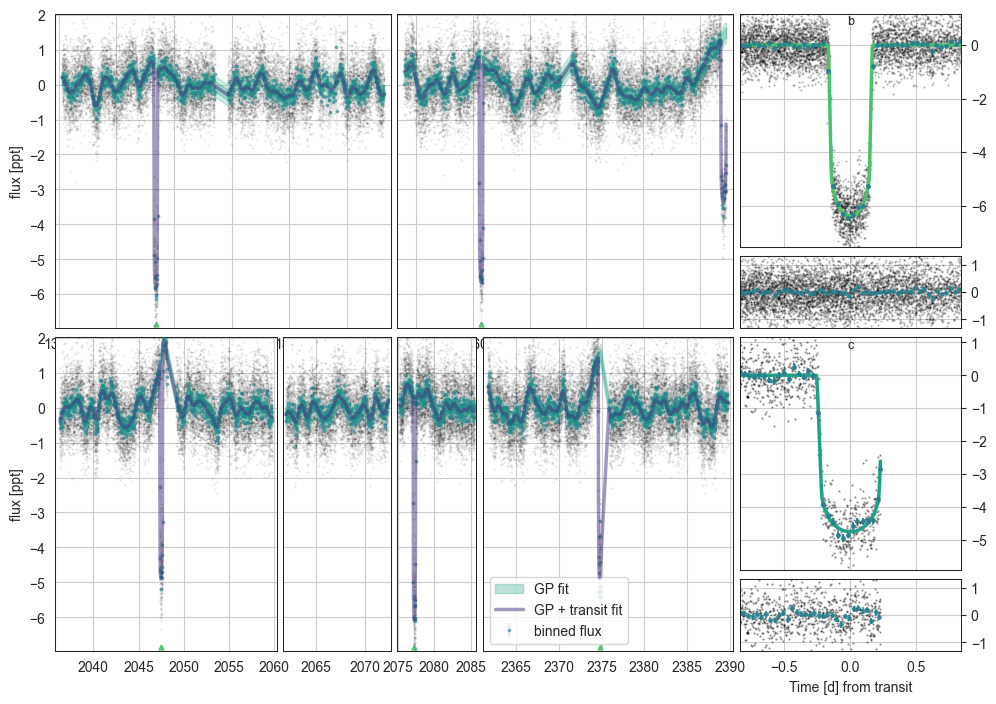

In [10]:
model.Plot(overwrite=True)

In we want to see in detail the initial solution, here it is:

In [12]:
model.init_soln['per_marg_c']

array(144.12207178)

### Running the MCMC
Now we can run the Mcmc using `model.RunMcmc`. We don't want this to take too long, so let's only get 500 draws per chain. For production-quality fits, there should thousands of effective samples.

NB - if a "broken pipe" error occurs, then you need to set `n_chains=1` because of Mac M1/2 problems with Pymc3.

In [14]:
model.SampleModel(n_burn_in=300, n_draws=500, n_chains=4)

Sequential sampling (1 chains in 1 job)
NUTS: [phot_mean, phot_power, phot_w0, logs2, u_star_tess, tdur_c, b_c, logror_c, mono_uniform_index_c, t0_c, b_b, omega_b, ecc_b_frac, ecc_b_sigma_rayleigh, ecc_b_sigma_gauss, ecc_b, logror_b, per_b, t0_b, Rs, logrho_S]


Sampling 1 chain for 300 tune and 500 draw iterations (300 + 500 draws total) took 515 seconds.
There were 450 divergences after tuning. Increase `target_accept` or reparameterize.
Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


Saving sampled model parameters to file with shape:  (650, 14)


#### Plotting
So now let's plot the results!

initialising transit
Initalising Transit models for plotting with n_samp= 990
Initalising GP models for plotting with n_samp= 99


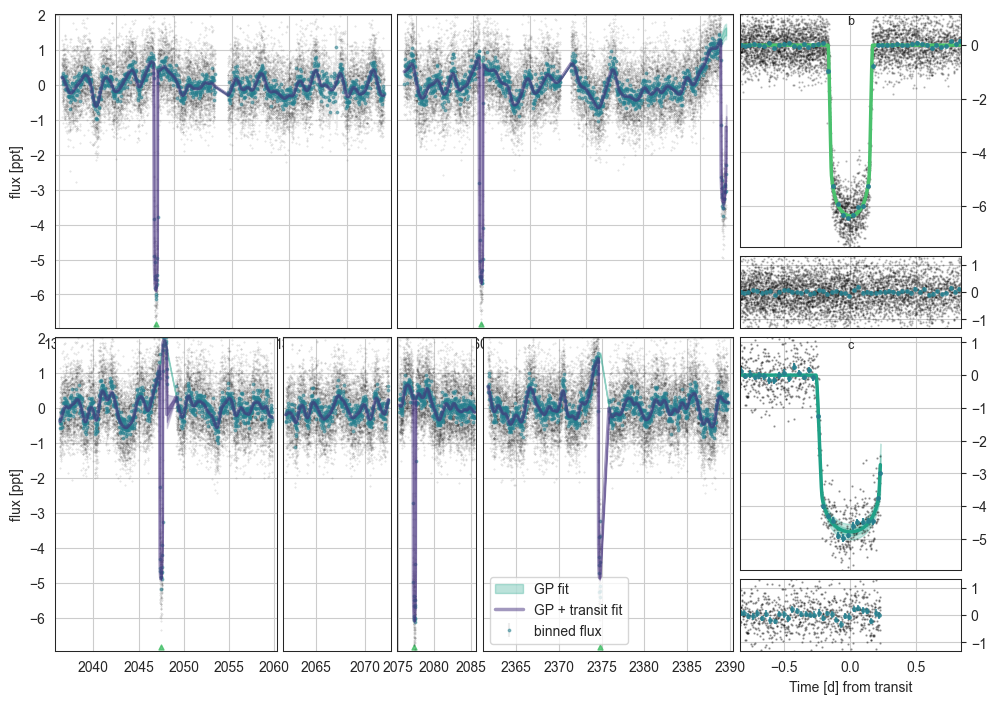

In [15]:
model.Plot(overwrite=True)
#This can be slow as we need to recreate the GP using the values in the trace (as we do not store the full GP prediction)

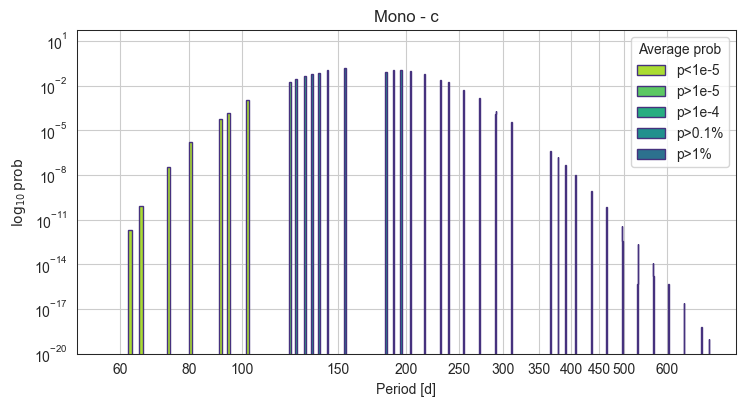

In [19]:
model.PlotPeriods(ylog=True, pmin=50, pmax=800,ymin=1e-20)

variables for Corner: ['logrho_S', 'logror_b', 'b_b', 'tdur_b', 't0_b', 'logror_c', 'b_c', 'tdur_c', 't0_c', 'per_marg_c', 'ecc_marg_c']
Pandas support in corner is deprecated; use ArviZ directly
Here's all of the potential parameters from the MCMC trace:
 ['logrho_S_interval__', 'Rs', 't0_b_interval__', 'per_b', 'logror_b_interval__', 'ecc_b_interval__', 'ecc_b_sigma_gauss_lowerbound__', 'ecc_b_sigma_rayleigh_lowerbound__', 'ecc_b_frac_interval__', 'omega_b_angle__', 'b_b_impact__', 't0_c_interval__', 'mono_uniform_index_c_logodds__', 'logror_c_interval__', 'b_c_impact__', 'tdur_c_interval__', 'u_star_tess_interval__', 'logs2', 'phot_w0_interval__', 'phot_power_interval__', 'phot_mean_interval__', 'logrho_S', 'rho_S', 'Ms', 't0_b', 'logror_b', 'ror_b', 'rpl_b', 'logmassest_b', 'ecc_b', 'ecc_b_sigma_gauss', 'ecc_b_sigma_rayleigh', 'ecc_b_frac', 'omega_b', 'b_b', 'a_Rs_b', 'incl_b', 't0_c', 'mono_uniform_index_c', 'per_c', 'logror_c', 'ror_c', 'rpl_c', 'logmassest_c', 'b_c', 'tdur_c', '

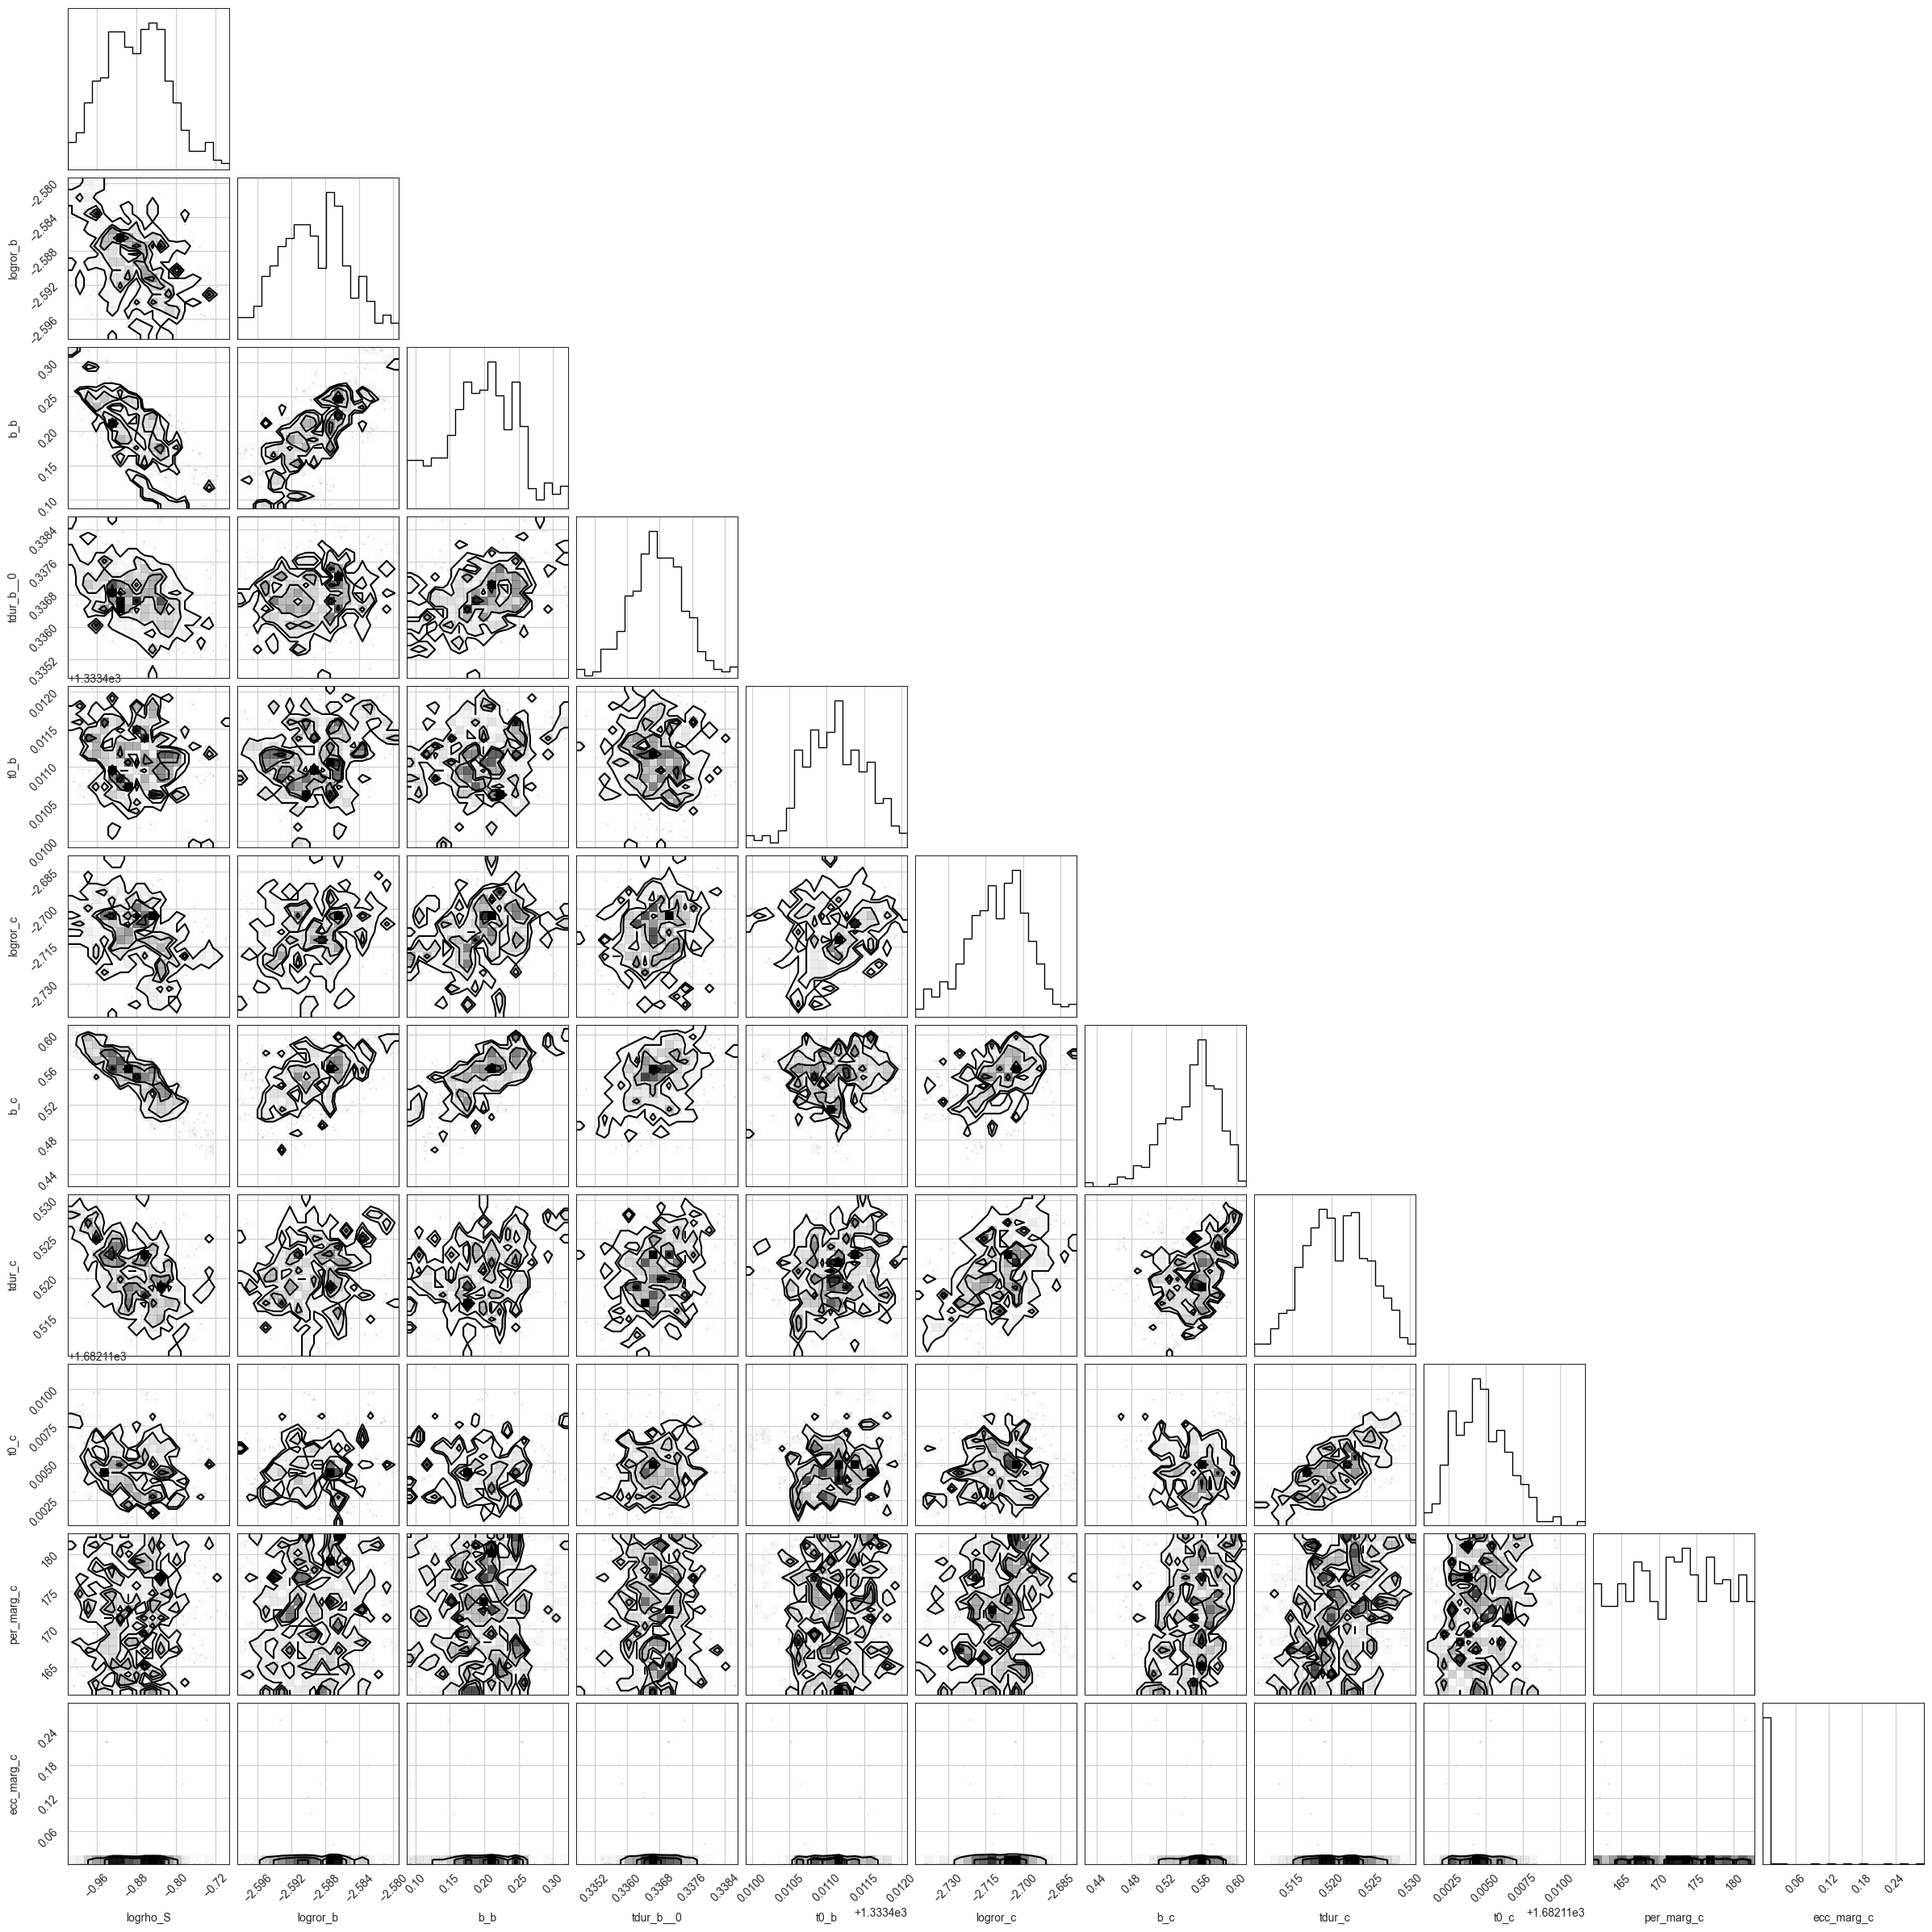

In [21]:
model.PlotCorner()

#We can set what we want to plot here using corner_vars.
print("Here's all of the potential parameters from the MCMC trace:\n",model.trace.varnames)

This was only a very quick MCMC trace so we don't have the best trace yet.

In order to access the probabilities for each gap of monotransit candidate, we can use the log probabilities within the trace:

In [22]:
{str(model.planets['c']['per_gaps']['gap_starts'][n_alias])[:6]+"-"+str(model.planets['c']['per_gaps']['gap_ends'][n_alias])[:6]:np.exp(np.nanmedian(model.trace['logprob_marg_c'][:,n_alias])) for n_alias in np.arange(model.planets['c']['ngaps'])[::-1]}


{'1173.4-1249.9': 5.898353843327051e-32,
 '1101.5-1173.4': 2.0194712284973675e-30,
 '1034.0-1101.5': 6.822158893845857e-29,
 '970.75-1034.0': 2.259342138423248e-27,
 '911.29-970.75': 7.281090003659415e-26,
 '855.47-911.29': 2.2677268515123224e-24,
 '803.07-855.47': 6.774213303031798e-23,
 '753.88-803.07': 1.9262881638032592e-21,
 '707.71-753.88': 5.1756186197828736e-20,
 '692.83-693.58': 2.5876373677863297e-19,
 '636.68-679.54': 1.0826096142434864e-17,
 '596.53-636.68': 2.640394557227678e-16,
 '558.91-596.53': 5.877046223604896e-15,
 '523.66-558.91': 1.1834982311079506e-13,
 '490.64-523.66': 2.1373644980612804e-12,
 '459.69-490.64': 3.434488706728463e-11,
 '430.70-459.69': 4.866825806351128e-10,
 '403.54-430.70': 6.035034598276973e-09,
 '390.43-392.94': 2.8591477863661704e-08,
 '377.79-379.56': 9.304693525765305e-08,
 '366.17-366.91': 2.7659041944200715e-07,
 '307.66-328.80': 4.3178466273332504e-05,
 '287.88-307.66': 0.00024679612737251626,
 '269.37-287.88': 0.0011729082111818104,
 '25

### Including RVs

To see how RVs would be included, see the `Fit_with_RVs_example.ipynb`example notebook